In [1]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as xfms
from pathlib import Path
from torch import Tensor

from tqdm import tqdm
from PIL import Image
import itertools
import cv2
from torchvision.utils import make_grid
import albumentations as A
import albumentations.pytorch.transforms as Atf
import torchvision.transforms as transforms


import torch.nn as nn
import torch.nn.functional as F

/home/user/VirtualEnv/jupyter/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.set_device(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device", torch.cuda.current_device(), torch.cuda.get_device_name(torch.cuda.current_device()))

device 0 NVIDIA GeForce RTX 2080 Ti


In [3]:
root = r'dataset'

In [4]:
class MyDataset(Dataset):
    def __init__(self, root_dir, split, first_transform=None, second_transform = None):
        self.img_dir = root_dir+'/images'
        self.mask_dir = root_dir+'/masks'
        self.first_transform = first_transform
        self.second_transform = second_transform
        self.train_set = {}
        self.test_set = {}
        self.split = split

        for class_dir in os.listdir(self.img_dir):
            image_dir_path = os.path.join(self.img_dir, class_dir)
            mask_dir_path = os.path.join(self.mask_dir, class_dir)
            file_num = len(os.listdir(image_dir_path))
            for i, img_file in enumerate(os.listdir(image_dir_path)):

                name = img_file.split('.')[0]

                image_path = os.path.join(image_dir_path, f'{name}.jpg')

                mask_path = os.path.join(mask_dir_path, f'{name}.png')
                if i<= file_num*7//10:
                    self.train_set[image_path] = mask_path
                else:
                    self.test_set[image_path] = mask_path


        self.train_set = self.shuffle_(self.train_set)
        self.test_set = self.shuffle_(self.test_set)

    def shuffle_(self, dataset):
        shuffle_dic = list(dataset.items())
        np.random.shuffle(shuffle_dic)
        dataset = dict(shuffle_dic)
        return dataset

    def __len__(self):
        if self.split == 'train':
            return len(self.train_set)
        else:
            return len(self.test_set)

    def __getitem__(self, idx):

        if self.split == 'train':
            dataset = self.train_set
        else:
            dataset = self.test_set

        image_path = list(dataset)[idx]
        img = np.array(Image.open(image_path))
        mask_path = list(dataset.values())[idx]
        mask = Image.open(mask_path)
        mask = np.array(mask)

        # print(image_path)
        # print(mask_path)
        if self.split == 'train':
            for i in range(3000):
                random_crop =  A.Compose([
                                A.RandomCrop(width=IMG_SIZE[1], height=IMG_SIZE[0]),
                                A.Rotate(limit=360, p=0.9, border_mode=cv2.BORDER_CONSTANT),

                ],additional_targets={'image0': 'image', 'mask': 'image'})
                transformed = random_crop(image = img, mask = mask)

                if np.max(transformed["mask"])!=0:
                    break

            transformed = self.first_transform(image = transformed["image"], mask = transformed["mask"])
            img = transformed["image"]
            mask = transformed["mask"]

        img = Image.fromarray(img)
        img = transforms.ToTensor()(img).to(torch.float64)
        mask =  torch.from_numpy(mask).unsqueeze(0).to(torch.long)

        return img, mask

In [5]:
split = ['train','test']
IMG_SIZE = [800, 800]
BATCH_SIZE = 12
INIT_LR = 0.001
EPOCHES = 3
amp = False

tds = MyDataset(root,
                split[0],
                A.Compose([
                            A.HorizontalFlip(p=0.5),
                            #Atf.ToTensorV2()
                            ],
                additional_targets={'image0': 'image', 'mask': 'image'}))

ttds = MyDataset(root, split[1])
print(tds[0][1].dtype)

torch.int64


In [6]:
print(len(tds))
print(len(ttds))

6546
2793


In [7]:
# functions to show an image
def compress_mask_C(masks, threshold):

    resultWH = torch.zeros(masks.shape[2], masks.shape[3])
    final_result = torch.zeros(masks.shape[0], 1, masks.shape[2], masks.shape[3])
    for i, mask in enumerate(masks):
        for channel, WH in enumerate(mask):
            resultWH[WH>threshold] = channel
        final_result[i][0] = resultWH
    return final_result
def contours_generate(input_img,fusion_img):
    input_img = np.float32(input_img)
    img_gray = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
    img_gray *= 255
    colors = [(255,50,0),(131,60,11),(0,255,0),(0,0,255),(255,0,255),(255,0,0),(0,0,128)]
    for threshhold in range(1,8):
        ret, thresh = cv2.threshold(np.uint8(img_gray),(threshhold*36-1), 255, cv2.THRESH_BINARY)
        contours, hierarchy = cv2.findContours(thresh, 3, 2)
        if contours:
            if threshhold == 1:
                hull = cv2.drawContours(fusion_img, contours, -1, colors[threshhold-2], 6)
            else:
                hull = cv2.drawContours(hull, contours, -1, colors[threshhold-2], 6)
    return hull

def vs_generate(input_mask, gen_mask, fusion):
    err_space = np.float64(np.logical_xor(input_mask, gen_mask))
    corr_space = np.logical_and(input_mask, gen_mask)

    R,G,B = cv2.split(err_space)
    R[R==0] = 0.18
    G[G==0] = 0.46
    G[G>0.46] = 0
    B[B==0] = 0.71
    B[B>0.71] = 0
    err_space =cv2.merge([R,G,B])
    err_space *= np.float64(np.logical_not(corr_space))
    corr_space = np.float64(corr_space)
    corr_space *= fusion
    err_space += corr_space
    return err_space

def show_images(input_imgs, input_masks: None, gen_masks= None,
                nrow=5, ncol=1, show: bool = True, name="", channels=3, mode: bool =False, img_size:list = []):
    # compare and show n*m images from generator in one figure and optionally save it
    figsize = (11,6)
    count = 311
    img_label = ["input images", "input mask"]
    inputs = [input_imgs, input_masks]

    if mode == True and gen_masks == None:
        print("Input ERROR! Expected [gen_mask] but got [None].")
        return None

    elif mode == True and gen_masks != None:
        figsize = (11,10)
        count = 611
        img_label.append("generated mask")
        inputs.append(gen_masks)

    plt.figure(figsize=figsize)
    for imgs, label in zip([imgs for imgs in inputs if input_masks is not None], img_label):
        imgs = imgs[:nrow * ncol]
        print(imgs.shape)
        imgs = imgs.view(imgs.size(0), imgs.size(1), img_size[0], img_size[1])
        print('after',torch.max(imgs))
        ax = plt.subplot(count)
        ax.set_title(label ,x=-0.1, y=0.4)

        # if imgs[0].shape[0] == 3:
        #     imgs = imgs*STD_MIN[0] + STD_MIN[1]
        #     img_list = []
        #     for i in range(imgs.shape[0]):
        #         img_ = np.transpose(np.array(imgs[i]), (1,2,0)).astype(np.float64)
        #         np_img = np.transpose(np.array(Image.fromarray((np.array(img_).astype(np.float64)))), (2, 0, 1))
        #         img_list.append(np_img)
        #
        #     imgs = torch.tensor(np.array(img_list))
        # else:
        #     imgs *= 255//7
        img = np.transpose(make_grid(imgs, nrow=nrow, padding=2, normalize=True).cpu(), (1, 2, 0))

        img = cv2.cvtColor(np.float32(np.array(img)), cv2.COLOR_BGR2RGB)
        #img = cv2.resize(img, (img.shape[1]*2, int(img.shape[0]*1.5)), interpolation=cv2.INTER_AREA)
        plt.axis("off")
        plt.imshow(img)

        if label == "input mask":
            input_mask = img
        if label == "generated mask":
            gen_mask = img

        if label == "input images":
            #origin_img = img/2

            origin_img = img/3 + 0.6


        else :
            count+=1
            ax = plt.subplot(count)
            name = label.split(" ")[0] + " fusion"
            ax.set_title(name,x=-0.1, y=0.4)
            fusion = origin_img.copy()
            hull = contours_generate(img,fusion)
            plt.axis("off")
            plt.imshow(hull)

        if label == "generated mask":
            count+=1
            ax = plt.subplot(count)
            name = "gt vs pred"
            ax.set_title(name,x=-0.1, y=0.4)
            fusion = origin_img.copy()
            vs = vs_generate(input_mask, gen_mask, fusion)
            #print(vs,)
            plt.axis("off")
            plt.imshow(vs)
        count+=1

    if show:
        plt.show()

In [8]:
tdl = DataLoader(tds, batch_size=BATCH_SIZE, shuffle=True)
vdl = DataLoader(ttds, batch_size=5, shuffle=True)

In [11]:
a = next(iter(tdl))
print(a[0].shape)

torch.Size([12, 3, 800, 800])


torch.Size([5, 3, 800, 800])
after tensor(0.9294, dtype=torch.float64)
torch.Size([5, 1, 800, 800])
after tensor(3.)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


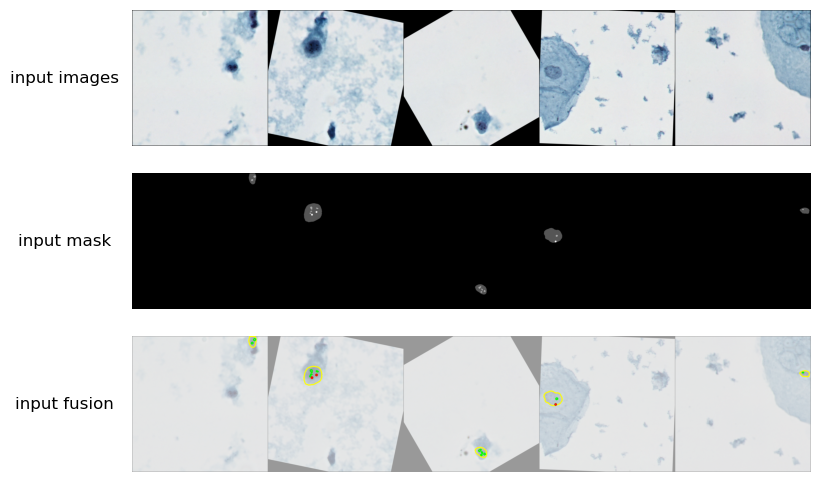

In [10]:
show_images(a[0], a[1].float(), img_size=IMG_SIZE)

In [12]:
def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [13]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.transConv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):

        return self.double_conv(x) #+ self.transConv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        #x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class attentionConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(attentionConv, self).__init__()

        self.same_conv1 = nn.Conv2d(out_channels, out_channels, kernel_size=1)
        self.same_conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=1)
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)


    def forward(self, q, k):
        #q.size = k.size/2
        q = self.up(q)
        k = self.same_conv1(k)
        a = q+k
        a = F.relu(a)
        a = self.same_conv2(a)
        a = F.sigmoid(a)
        a = a*k

        return a

a = attentionConv(256, 128)
q = torch.randn(8, 256, 32, 32)
k = torch.randn(8, 128, 64, 64)
out = a(q, k)
out.shape

/mnt/tapioca/miniconda3/envs/hw/lib/python3.9/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


torch.Size([8, 128, 64, 64])

In [14]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 32))
        self.down1 = (Down(32, 64))
        self.down2 = (Down(64, 128))
        self.down3 = (Down(128, 256))
        factor = 2 if bilinear else 1
        #self.down4 = (Down(256, 512 // factor))
        #self.up1 = (Up(512, 256 // factor, bilinear))
        self.up2 = (Up(256, 128 // factor, bilinear))
        self.up3 = (Up(128, 64 // factor, bilinear))
        self.up4 = (Up(64, 32, bilinear))
        self.outc = (OutConv(32, n_classes))

        self.att2 = (attentionConv(256, 128))
        self.att3 = (attentionConv(128, 64))
        self.att4 = (attentionConv(64, 32))

    def forward(self, x):
        x1 = self.inc(x)        # out : 32, 800, 800
        x2 = self.down1(x1)     # out : 64, 400, 400
        x3 = self.down2(x2)     # out : 128, 200, 200
        x4 = self.down3(x3)     # out : 256, 100, 100
        #x5 = self.down4(x4)     # out : 1024, 50, 50
        #x = self.up1(x5, x4)
        a4 = self.att2(x4, x3)
        x = self.up2(a4, x3)
        a3 = self.att3(x, x2)
        x = self.up3(a3, x2)
        a2 = self.att4(x, x1)
        x = self.up4(a2, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

In [15]:
weights_root = Path("weights_final")
print(weights_root)
weights_root.mkdir(exist_ok=True)

#unet = UNet(n_channels=3, n_classes=8).to(device)

unet = torch.nn.DataParallel(UNet(n_channels=3, n_classes=8).to(device),
                             device_ids=[0,1]#, 3, 4, 5, 6, 7]
                             )

opt = Adam(unet.parameters(), lr=INIT_LR)

grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
criterion = nn.CrossEntropyLoss() if UNet(n_channels=3, n_classes=8).n_classes > 1 else nn.BCEWithLogitsLoss()
global_step = 0
H = {"train_loss": [], "test_loss": []}

weights_final


In [ ]:
sstartTime = time.time()
for epoch in range(1, EPOCHES + 1):
        unet.train()
        totalTrainLoss = torch.Tensor([0]).to(device)
        totalTestLoss = torch.Tensor([0]).to(device)
        with tqdm(total=len(tds), desc=f'Epoch {epoch}/{EPOCHES}', unit='img') as pbar:
            for batch in tdl:
                images, true_masks = batch[0], batch[1]

                images = images.to(device=device, dtype=torch.float32)
                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                    masks_pred = unet(images)
                    loss = criterion(masks_pred, true_masks.squeeze(1))
                    dice_losses = 0
                    for B_i in range(true_masks.shape[0]):
                        # print('pred',F.softmax(masks_pred[B_i], dim=1).shape)
                        # print('true',F.one_hot(true_masks[B_i], 8).permute(0, 3, 1, 2).shape)
                        dice_losses += dice_loss(
                            F.softmax(masks_pred[B_i].unsqueeze(0), dim=1).float(),
                            F.one_hot(true_masks[B_i], 8).permute(0, 3, 1, 2).float(),
                            multiclass=True
                        )
                    loss += dice_losses/true_masks.shape[0]

                opt.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(unet.parameters(), 1)
                grad_scaler.step(opt)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1

                totalTrainLoss += loss

                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Evaluation round
                # division_step = (len(tds) // (5 * BATCH_SIZE))

                # val


            with torch.no_grad():
                unet.eval()
                with tqdm(total=len(ttds), desc=f'Epoch {epoch}/{EPOCHES}', unit='img') as pbar:
                    for batch in vdl:

                        images, true_masks = batch[0], batch[1]

                        images = images.to(device=device, dtype=torch.float32)
                        true_masks = true_masks.to(device=device, dtype=torch.long)

                        masks_pred = unet(images)
                        test_loss = criterion(masks_pred, true_masks.squeeze(1))

                        dice_losses = 0
                        for B_i in range(true_masks.shape[0]):
                            # print('pred',F.softmax(masks_pred[B_i].unsqueeze(0), dim=1).shape)
                            # print('true',F.one_hot(true_masks[B_i], 8).permute(0, 3, 1, 2).shape)
                            dice_losses += dice_loss(
                                F.softmax(masks_pred[B_i].unsqueeze(0), dim=1).float(),
                                F.one_hot(true_masks[B_i], 8).permute(0, 3, 1, 2).float(),
                                multiclass=True
                            )
                        test_loss += dice_losses/true_masks.shape[0]

                        totalTestLoss += test_loss
                        #anno = all_metrics(pred, y, show=False)
                        pbar.update(images.shape[0])
                        pbar.set_postfix(**{'loss (batch)': test_loss.item()})

            # calculate the average training and validation loss
            avgTrainLoss = (totalTrainLoss.cpu().item() / len(tdl))
            avgTestLoss = (totalTestLoss.cpu().item() / len(vdl))
            # if H["test_loss"] and avgTestLoss < np.min(H["test_loss"]):
            torch.save(unet.state_dict(), f"{weights_root}/{avgTestLoss:.4f}_{epoch+1:03}.pth")
            # update our training history
            H["train_loss"].append(avgTrainLoss)
            H["test_loss"].append(avgTestLoss)
            # print the model training and validation information

Epoch 1/3:  60%|███████████████████████████▋                  | 3936/6546 [06:50<04:11, 10.39img/s, loss (batch)=0.0477]

In [19]:
print(images.shape)
true_masks.shape

NameError: name 'images' is not defined

In [17]:
weights_root = './weights_attention'
weight = '0.0348_021.pth'
PATH = os.path.join(weights_root, weight)
#unet = UNet(n_channels=3, n_classes=8).to(device)
unet.load_state_dict(torch.load(PATH))
for batch in vdl:
    images, true_masks = batch[0], batch[1]

    images = images.to(device=device, dtype=torch.float32)
    true_masks = true_masks


    pred = unet(images)
    images = images.cpu()
    pred = pred.cpu()
    print(true_masks.dtype)
    print(pred.shape)


    break

torch.uint8
torch.Size([5, 8, 1200, 1600])


torch.Size([5, 8, 1200, 1600])
after tensor(-0.6220)
after tensor(7.)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


after tensor(4.)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


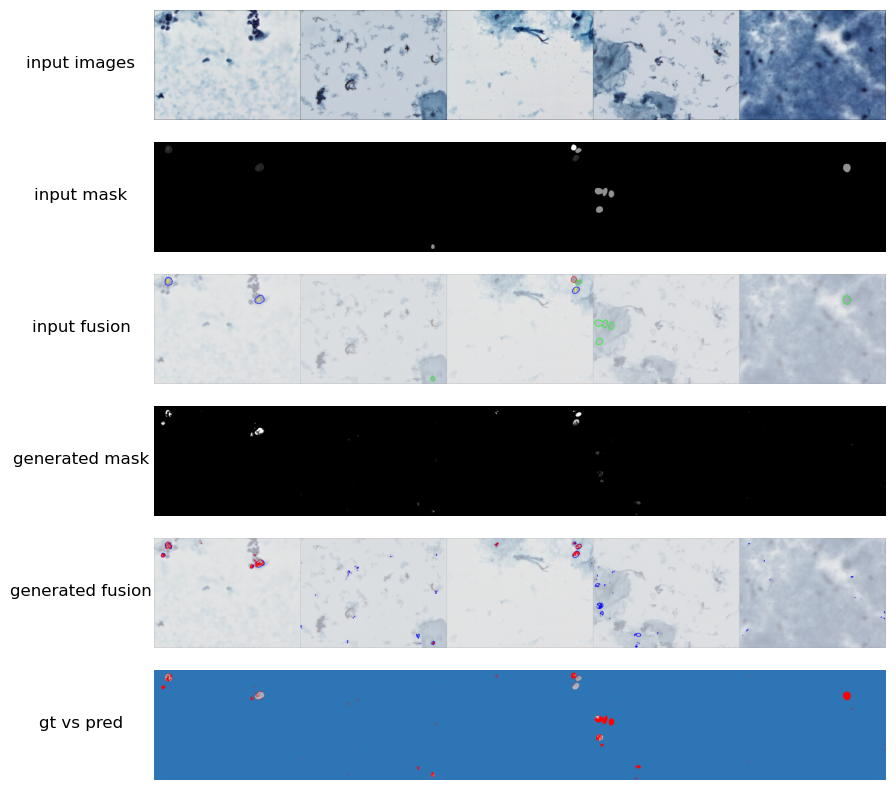

In [18]:
pred2show = compress_mask_C(pred, 0.1)
print(pred.shape)
show_images(images, true_masks.float(), gen_masks=pred2show,img_size=[1200,1600] , mode=True)

In [23]:
pred2show = compress_mask_C(pred, 0.05)
show_images(images, true_masks.float(), gen_masks=pred2show,img_size=IMG_SIZE , mode=True)

tensor(-3.3400, grad_fn=<MeanBackward0>)

In [38]:
pred[0][0].dtype

torch.float32

In [47]:
pred

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
    